In [1]:
from pandas import *
from numpy import *
from matplotlib.pyplot import *

from utils.workspace import Workspace
from scanpy.preprocessing import neighbors
from scanpy.tools import umap,dendrogram

from scanpy.plotting._tools.scatterplots import _get_data_points
from scanpy.plotting import stacked_violin
from scanpy.plotting import umap as plot_umap

from matplotlib.collections import PolyCollection,PatchCollection
from matplotlib.ticker import EngFormatter
from seaborn import violinplot,color_palette
from matplotlib.patches import Rectangle

from scanpy import settings
settings.verbosity = 3
settings.set_figure_params(dpi=80, facecolor='white')

from warnings import filterwarnings
from numba import NumbaDeprecationWarning
filterwarnings('ignore', category=NumbaDeprecationWarning)

from matplotlib import rcParams
from cycler import cycler
rcParams['axes.prop_cycle'] = cycler( color=[ '#%02x%02x%02x'%tuple((255*array(color)).astype(int)) for color in color_palette('Set3') ] )

palette = [
    'darkblue','lightblue','orange','gold',
    'royalblue','green','green','green','green','darkred',
    'darkblue','lightblue','orange','gold',
    'black','black'
]

SMALL_SIZE = 8
MEDIUM_SIZE = 30
BIGGER_SIZE = 30

rc('font', size=SMALL_SIZE)          # controls default text sizes
rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

######################################## channels
channels = {
    
    'FJComp-355 379_28-A': 'CD3', 

    'FJComp-355 560_40-A': 'CD8', 
    'FJComp-355 820_60-A': 'CD4',
    'FJComp-355 670_30-A': 'CD4',

    'FJComp-640 780_60-A': 'CCR7',
    'FJComp-405 780_60-A': 'CD45RA', 

    'FJComp-561 780_60-A': 'CD127', 
    'FJComp-640 670_30-A': 'CD25', 
    
    'FJComp-561 610_20-A': 'Helios', 
    'FJComp-561 585_15-A': 'Foxp3', 
    
    'FJComp-405 710_40-A': 'PD-1', 
    'FJComp-640 730_35-A': 'CXCR5', 
    
    'FJComp-405 670_30-A': 'CCR6', 
    'FJComp-488 715_30-A': 'CXCR3', 

    'FJComp-405 605_40-A': 'CCR4', 
    'FJComp-488 525_50-A': 'CCR10', 

    'FJComp-405 450_50-A': 'CD103', 
    'FJComp-355 740_35-A': 'CD69',
    'FJComp-405 515_20-A': 'HLA-DR'
}

######################################## condition parser
from re import search
def parser(file_path) :
    '''get tissue and patient id from filepath'''

    try :
        tissue = search('_(.+?)_',file_path).group()
        tissue = 'Blood' if 'Blood' in tissue else tissue[1:-1]
    except :
        tissue = ''

    try :
        patient = search('[0-9]+C',file_path).group()
    except :
        patient = ''

    return {'patient':patient,'tissue':tissue}


######################################### data import 
workspace = Workspace( 'data/workspace.wsp', thresholds = 'data/thresholds.csv',
                      channels = channels, condition_parser = parser)

## Data Exploration and Quality Assurance
The first step of the pipeline is for the expert flow cytometrist to verify correctness of the gating strategy, which is used to label data. Use FlowJo to create the `workspace.wsp` file, from which the gating strategy is imported. You must also verify the locations of negative control thresholds, specified in compensated fluorescence units in the file `thresholds.csv`.

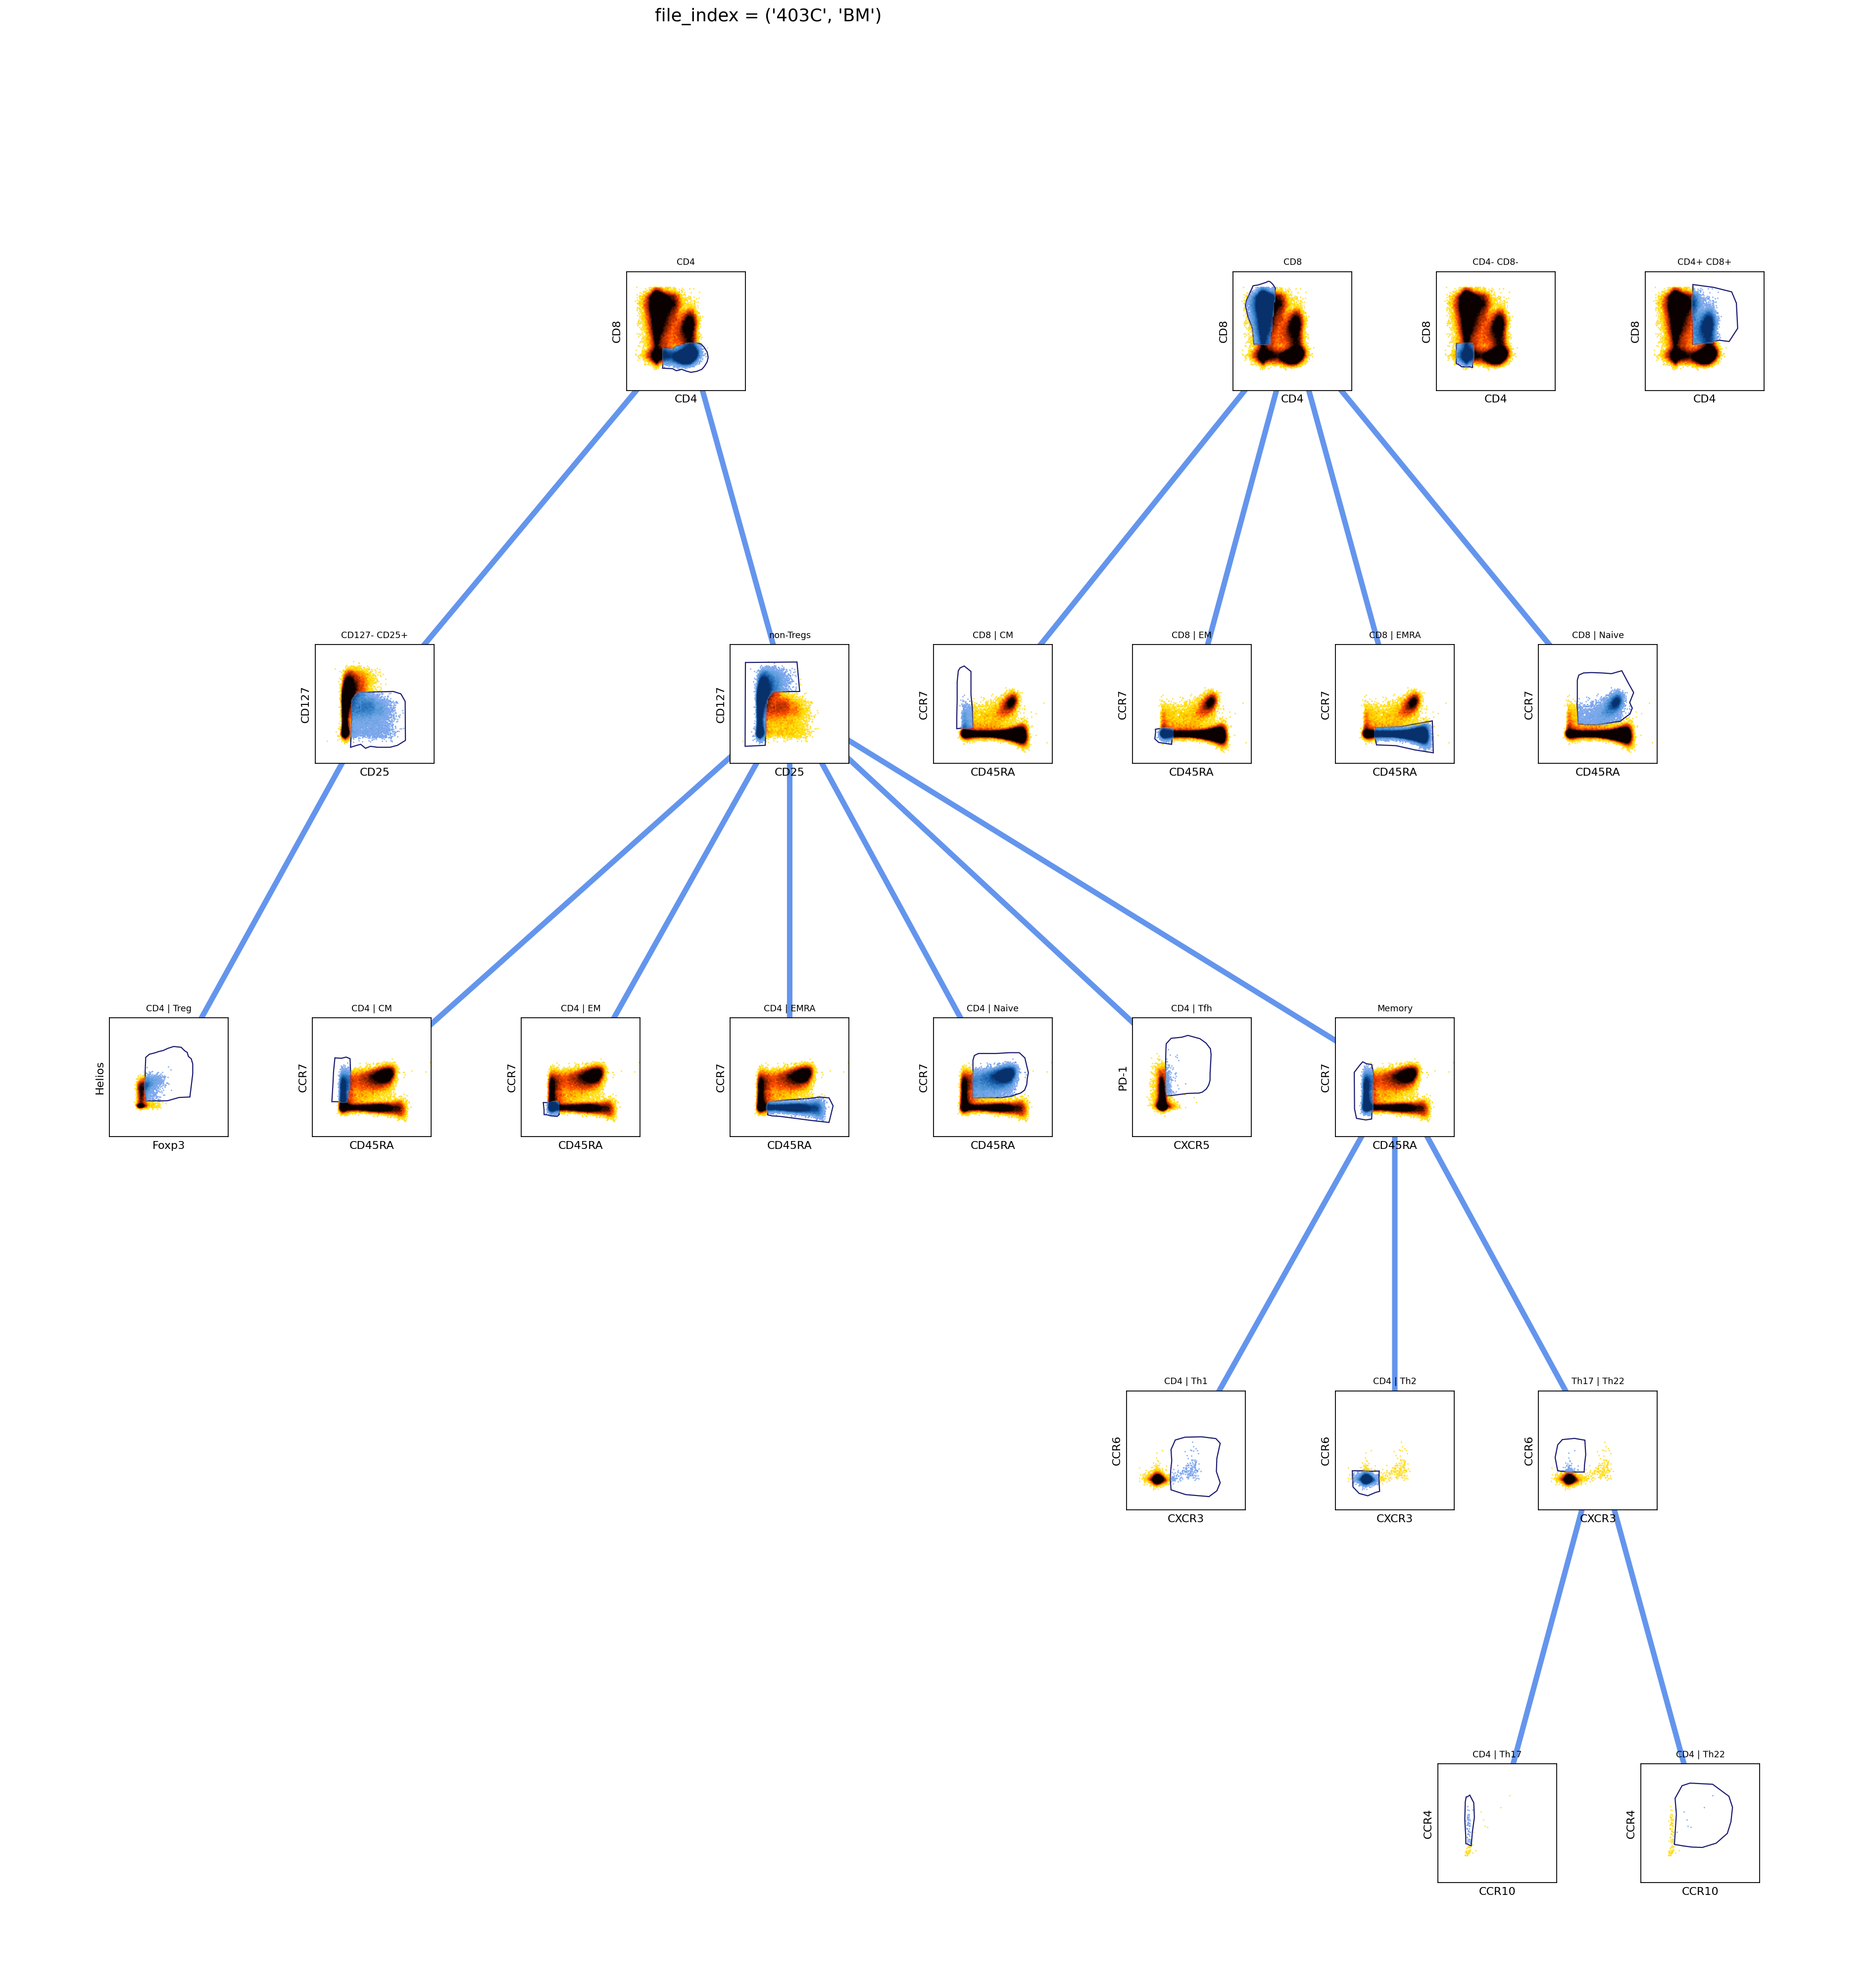

In [2]:
# show gating strategy for one file
workspace.show(('403C','BM'))

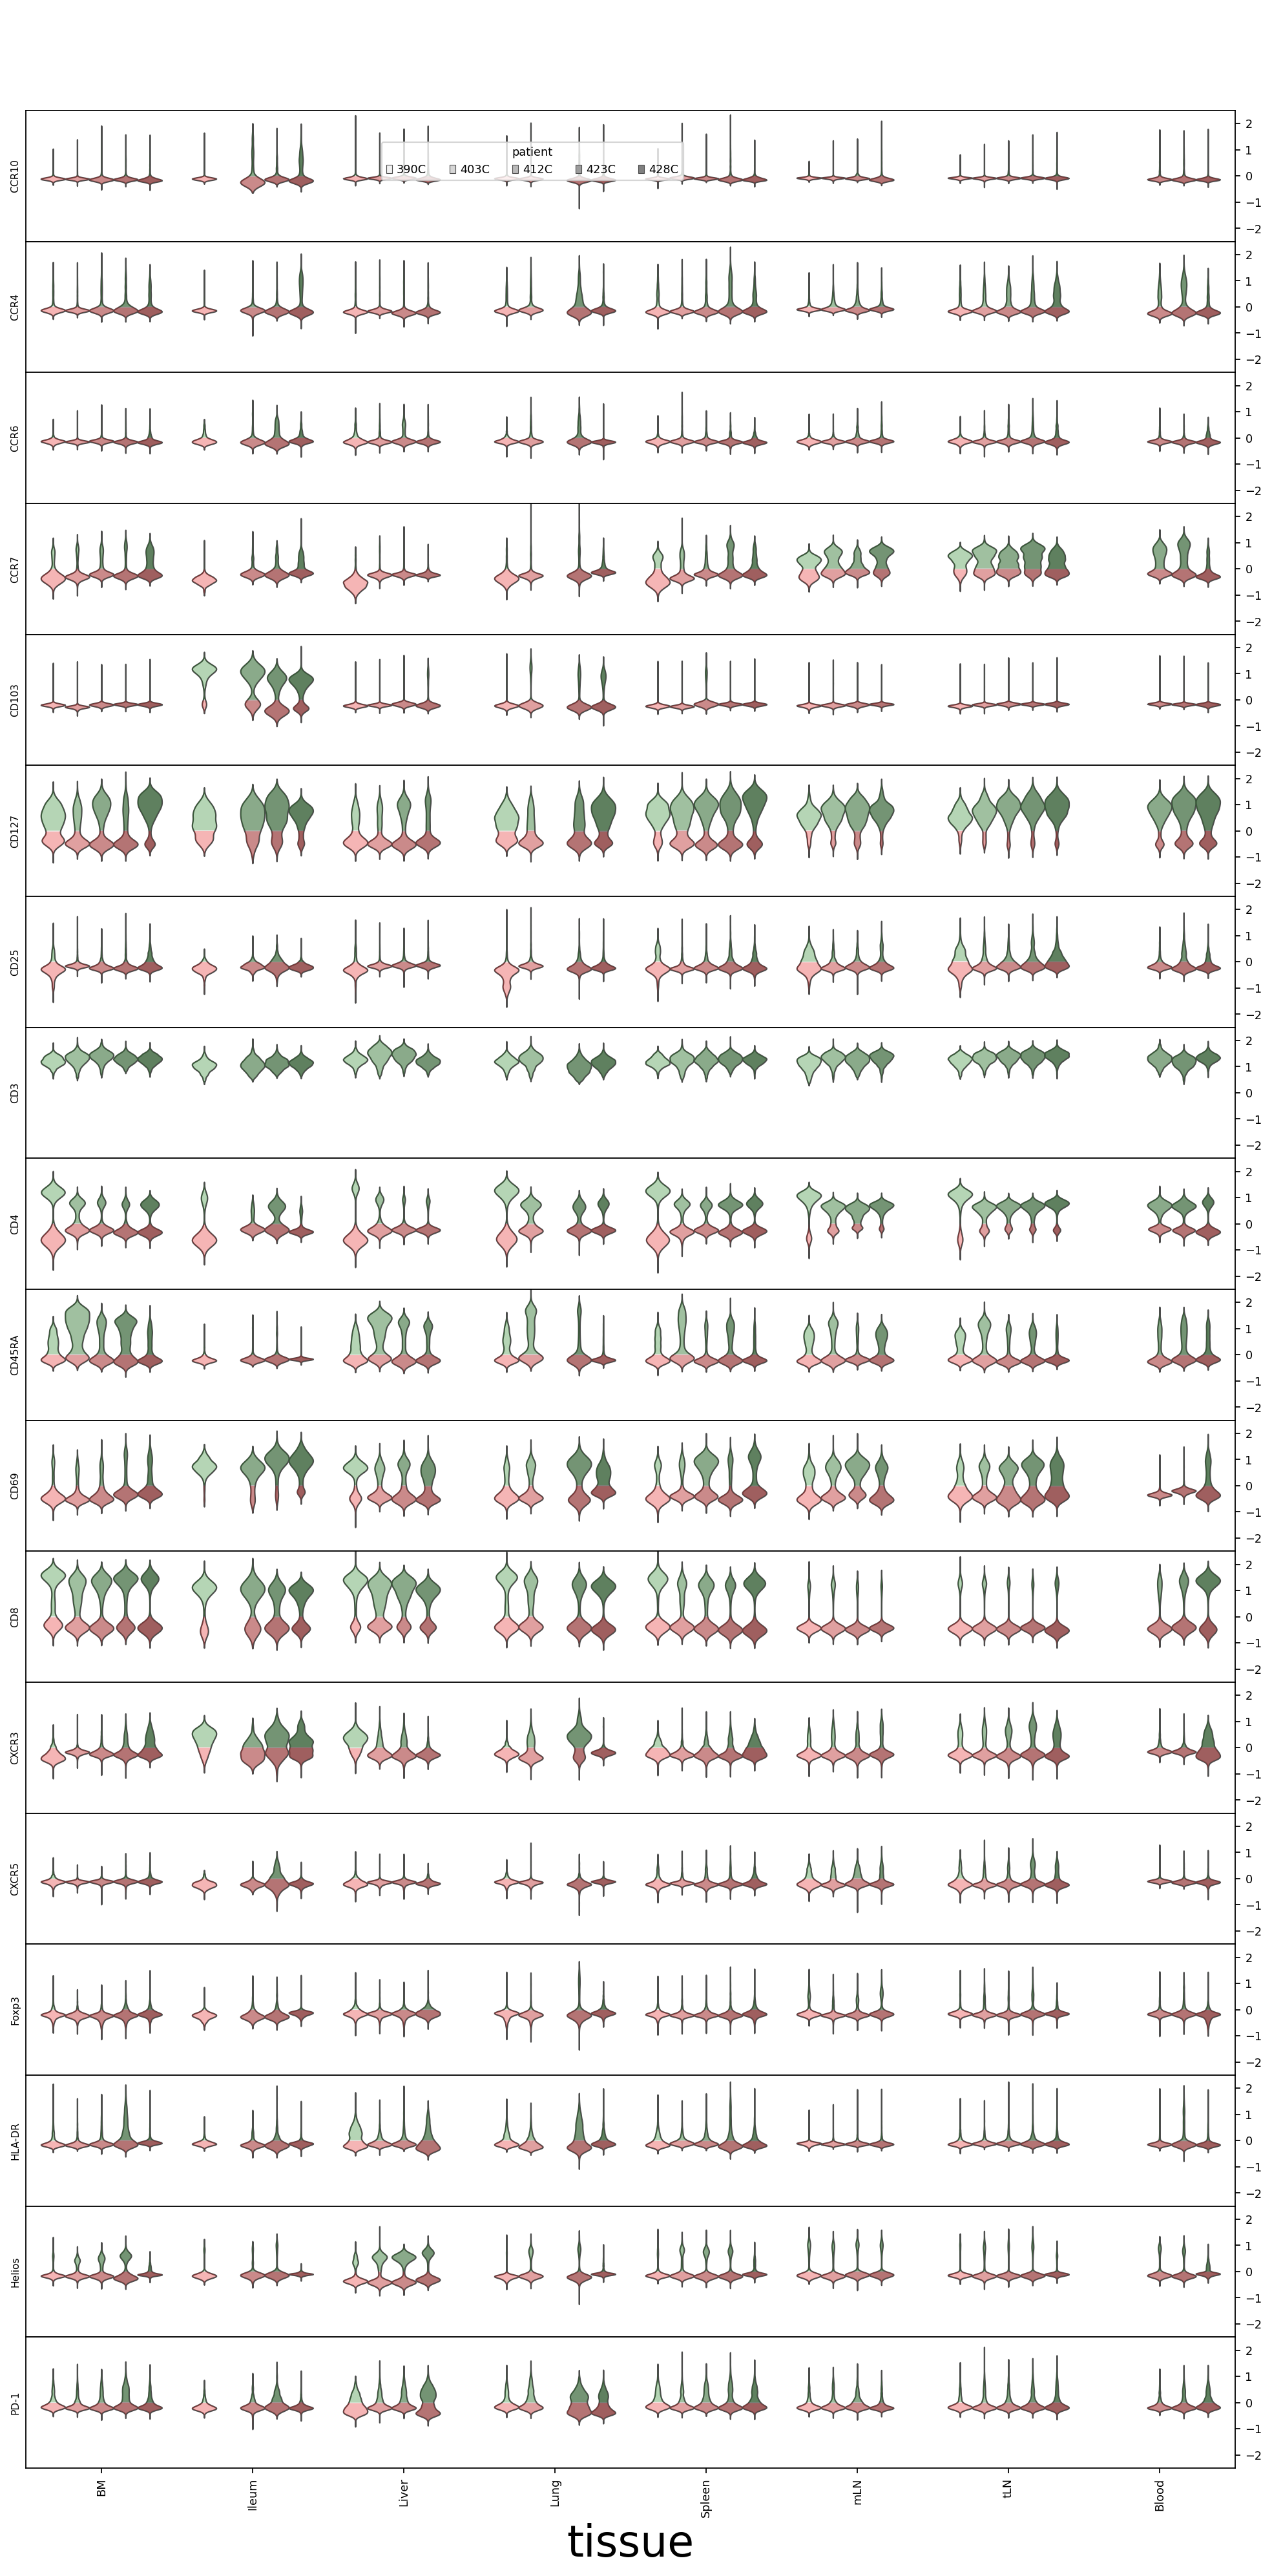

In [3]:
workspace.violinplot(x='tissue', hue='patient')

In [4]:
# workspace.thresholds.to_csv('data/thresholds.csv')

## Assign Clusters from Thresholds
Compensated fluoresence units centred around thresholds in `thresholds.csv`. This way the fluoresence units guaranteed to be positive/negative for cells that are positive/negative the corresponding marker. We assign each cell a `cluster_id` that is a binary encoding of its marker activation. The more significant bits encode higher-level markers

In [5]:
################################################# assign clusters
sample = workspace.sample(n=30000)
minimum_cells = 100

# binary encoding
clusters = (sample.data-workspace.thresholds>0).apply(
    lambda x: ''.join( array(x).astype(int).astype(str) ),
axis=1).to_frame(name='cluster')

# keep category dtypes
for level in range(clusters.index.nlevels-1) : 
    clusters.index.set_levels( clusters.index.levels[level].astype('category'), level=level, inplace=True)

# remove clusters with cells below threshold
mask = clusters.reset_index('cell').groupby('cluster').count() > minimum_cells
clusters = clusters[clusters.isin(mask[mask].dropna().index)].sort_index().astype('category')

######################################## convert to multilabels; dropping intermediate gates
labels = sample.labels.drop(columns=['CD4','CD8','Memory','Th17 | Th22','CD127- CD25+','non-Tregs'])
labels = labels.melt(ignore_index=False,var_name='label')
labels = labels[labels.value].drop(columns='value').sort_index().astype('category')

In [6]:
print('{:.1f}% events not clustered'.format(100*sample.data.join(clusters,how='left').cluster.isna().mean()))
print('{:.1f}% events not labelled'.format(100*sample.data.join(labels,how='left').label.isna().mean()))

22.0% events not clustered
4.4% events not labelled


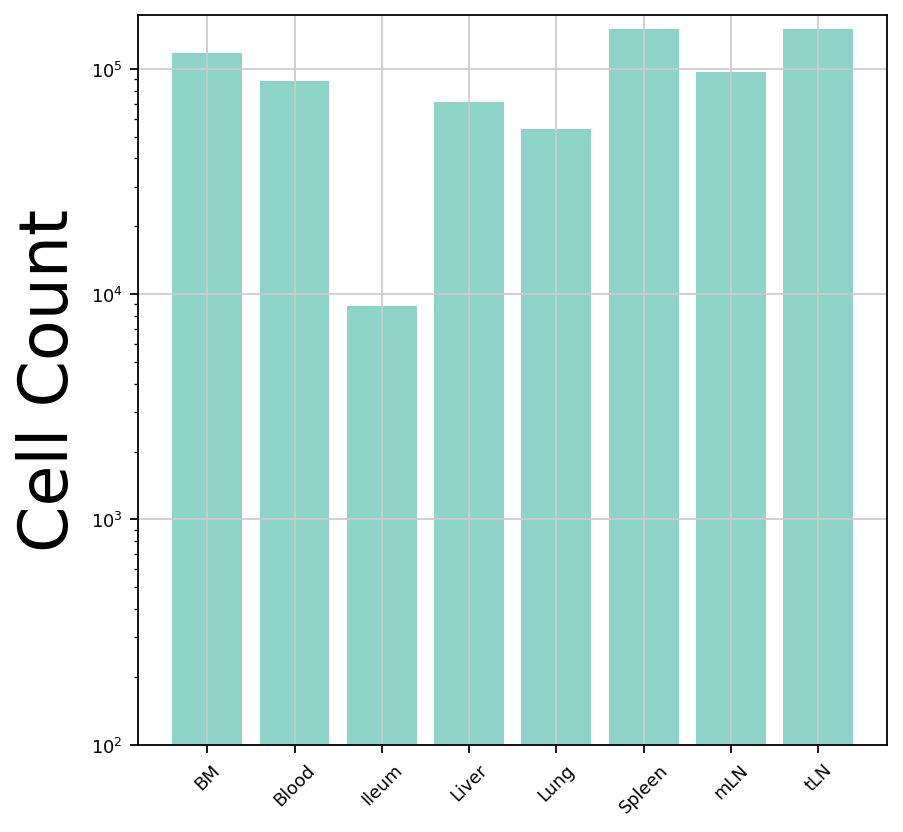

In [7]:
tissue_counts = sample.reset_index('cell').groupby('tissue').cell.count()

figure(figsize=(6,6))
bar(tissue_counts.index,tissue_counts)

ylabel('Cell Count'); yscale('log')
ylim(1e2,); xticks(rotation=45);

## Annotate Clusters
We calculate the population fraction for each `cluster_id` that belongs to a particular `label`. We then z-score across each annotation and threshold the most likely `cluster_ids` that have the same annotation. This is a greedy approach to optimise the annotiation of binary encoded clusters.

In [8]:
zscore_threshold = 1/2

################################################ project clusters onto labels; greedy approach
overlap_matrix = clusters.join(labels,how='left').reset_index('cell').groupby(['label','cluster']).count().unstack().droplevel(0,axis=1)
overlap_matrix = overlap_matrix.transform(lambda x: x / x.sum(), axis=0)
overlap_matrix = overlap_matrix.transform(lambda x: ( x - x.mean() ) / x.std(), axis=1)

############################################# map cluster_ids to human readable labels
selected = overlap_matrix > zscore_threshold

predictions = selected.transpose().melt(ignore_index=False,var_name='prediction')
predictions = predictions[predictions.value].drop(columns='value').sort_index().astype('category')
predictions.index.name = 'cluster'

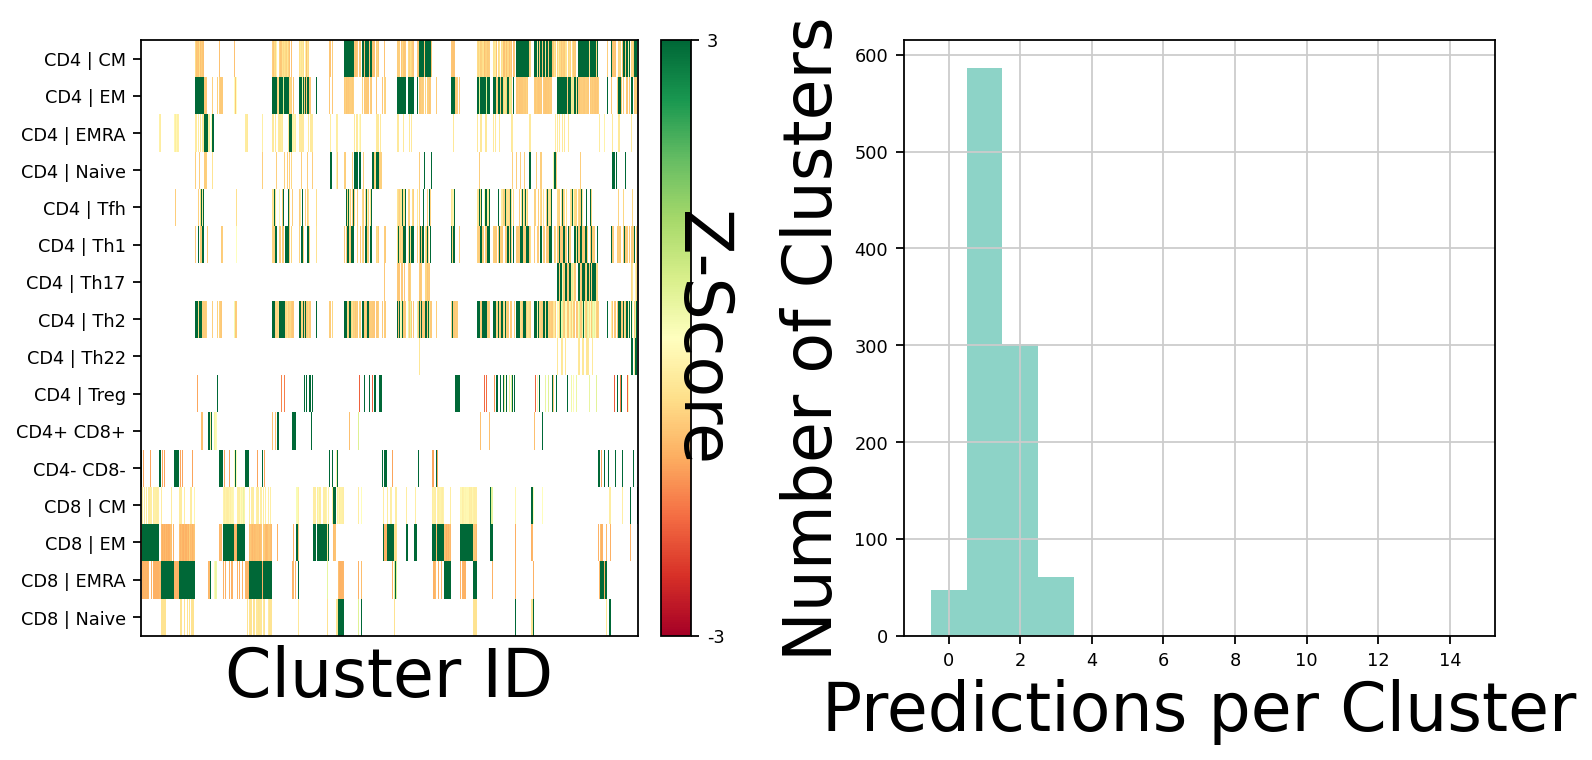

In [9]:
fig = figure(figsize=(10,5))
fig.add_subplot(121)
aspect = 1.2/divide(*overlap_matrix.shape)

ax = matshow( overlap_matrix,aspect=aspect, cmap='RdYlGn', vmin=-3, vmax=3, fignum=False)
matshow( selected.astype(int).replace(to_replace={0:NaN}), aspect=aspect, cmap='RdYlGn', vmin=0, vmax=1, fignum=False)

yticks(range(overlap_matrix.index.size),overlap_matrix.index)
ax.axes.xaxis.set_ticks_position('bottom')
grid(False)

cbar = colorbar(ax,fraction=0.054, pad=0.04, ticks=[-3,3])
cbar.ax.set_yticklabels([-3,3])

cbar.ax.set_ylabel('Z-Score', rotation=270)
xlabel('Cluster ID')
xticks([])

fig.add_subplot(122)
DataFrame(index=overlap_matrix.columns).join( predictions, how='left'
    ).groupby('cluster').prediction.count().hist(bins=arange(16)-0.5)

xlabel('Predictions per Cluster')
ylabel('Number of Clusters');
tight_layout(pad=2.5);

In [10]:
sample_results = sample.data.join(clusters.join(predictions,how='left',on='cluster'),how='left')
print('{:.1f}% events with no prediction'.format( 100*sample_results.prediction.isna().mean() ))

novel = sample_results.prediction.isna() & ~sample_results.cluster.isna() 
print('{:.1f}% novel events'.format( 100*novel.mean() ))

19.0% events with no prediction
1.4% novel events


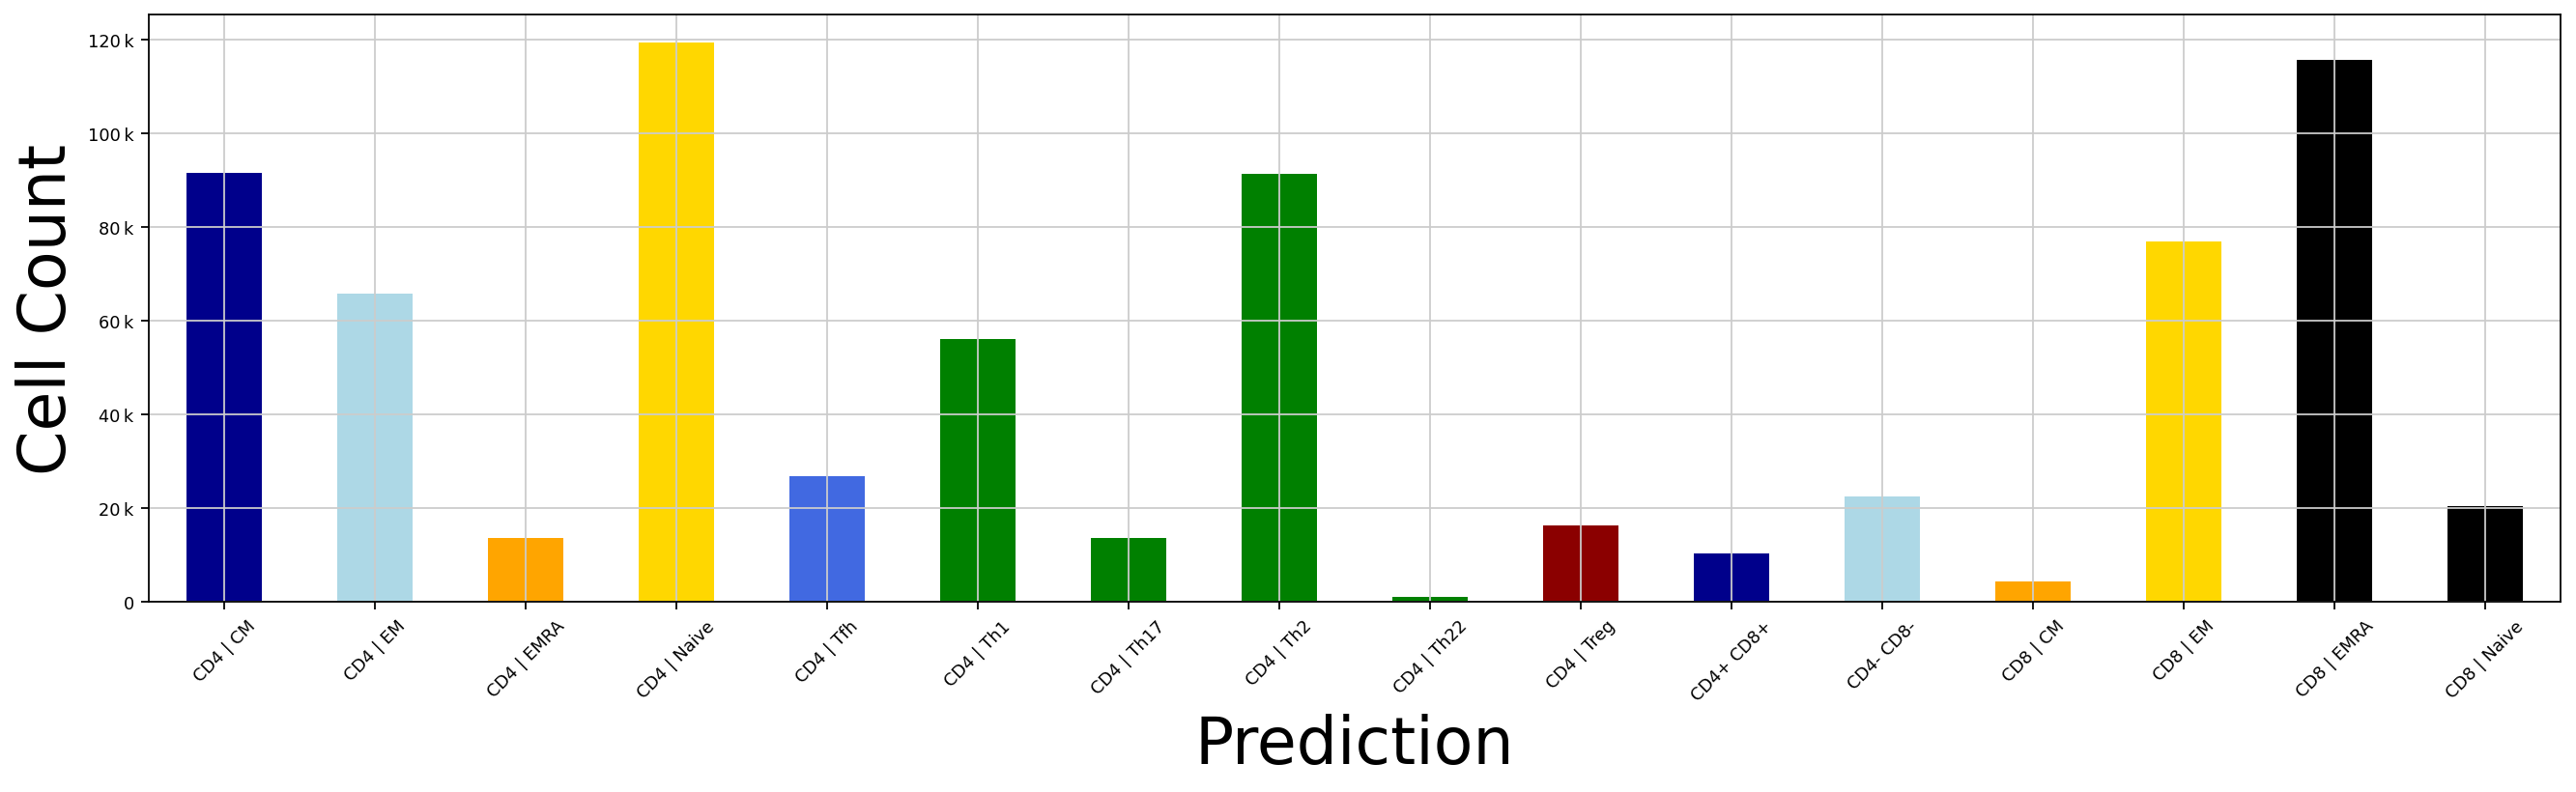

In [11]:
fig = figure(figsize=(20,5))
ax = fig.add_subplot(111)

clusters.join(predictions,how='left',on='cluster').reset_index('cell') \
.groupby('prediction').cell.count().plot.bar(ax=ax,color=palette)

ax.yaxis.set_major_formatter(EngFormatter(places=0, sep="\N{THIN SPACE}"))

ax.set_ylabel('Cell Count')
ax.set_xlabel('Prediction')
xticks(rotation=45);

## Confusion Matrix
Here we use the multi-label confusion matrix to visualise agreement between automated and human labelling

In [12]:
###################################################################### coocurance matrix
cooccurrence_threshold = 0.3

cooccurrence = labels.join(labels.rename(columns={'label':'prediction'}),how='left') \
.reset_index('cell') \
.groupby(['label','prediction']).count().unstack().droplevel(0,axis=1)

cooccurrence = concat([ # fractions of cooccurrences
    cooccurrence.transform(lambda x: x / x.max(), axis=0),
    cooccurrence.transform(lambda x: x / x.max(), axis=1)
    
]).max(level=0) # take larger triangle of fractions
cooccurrence[cooccurrence==1] = NaN

######################################################################## confusion matrix
confusion_matrix = clusters.join(labels,how='left').join(predictions,on='cluster',how='left') \
.drop(columns='cluster').reset_index('cell') \
.groupby(['label','prediction']).count().unstack().droplevel(0,axis=1)

for i,j in cooccurrence[cooccurrence>cooccurrence_threshold].stack().index :
    confusion_matrix[i][j] = NaN
    confusion_matrix[j][i] = NaN

/home/gszep/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
/home/gszep/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/gszep/.local/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/gszep/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator


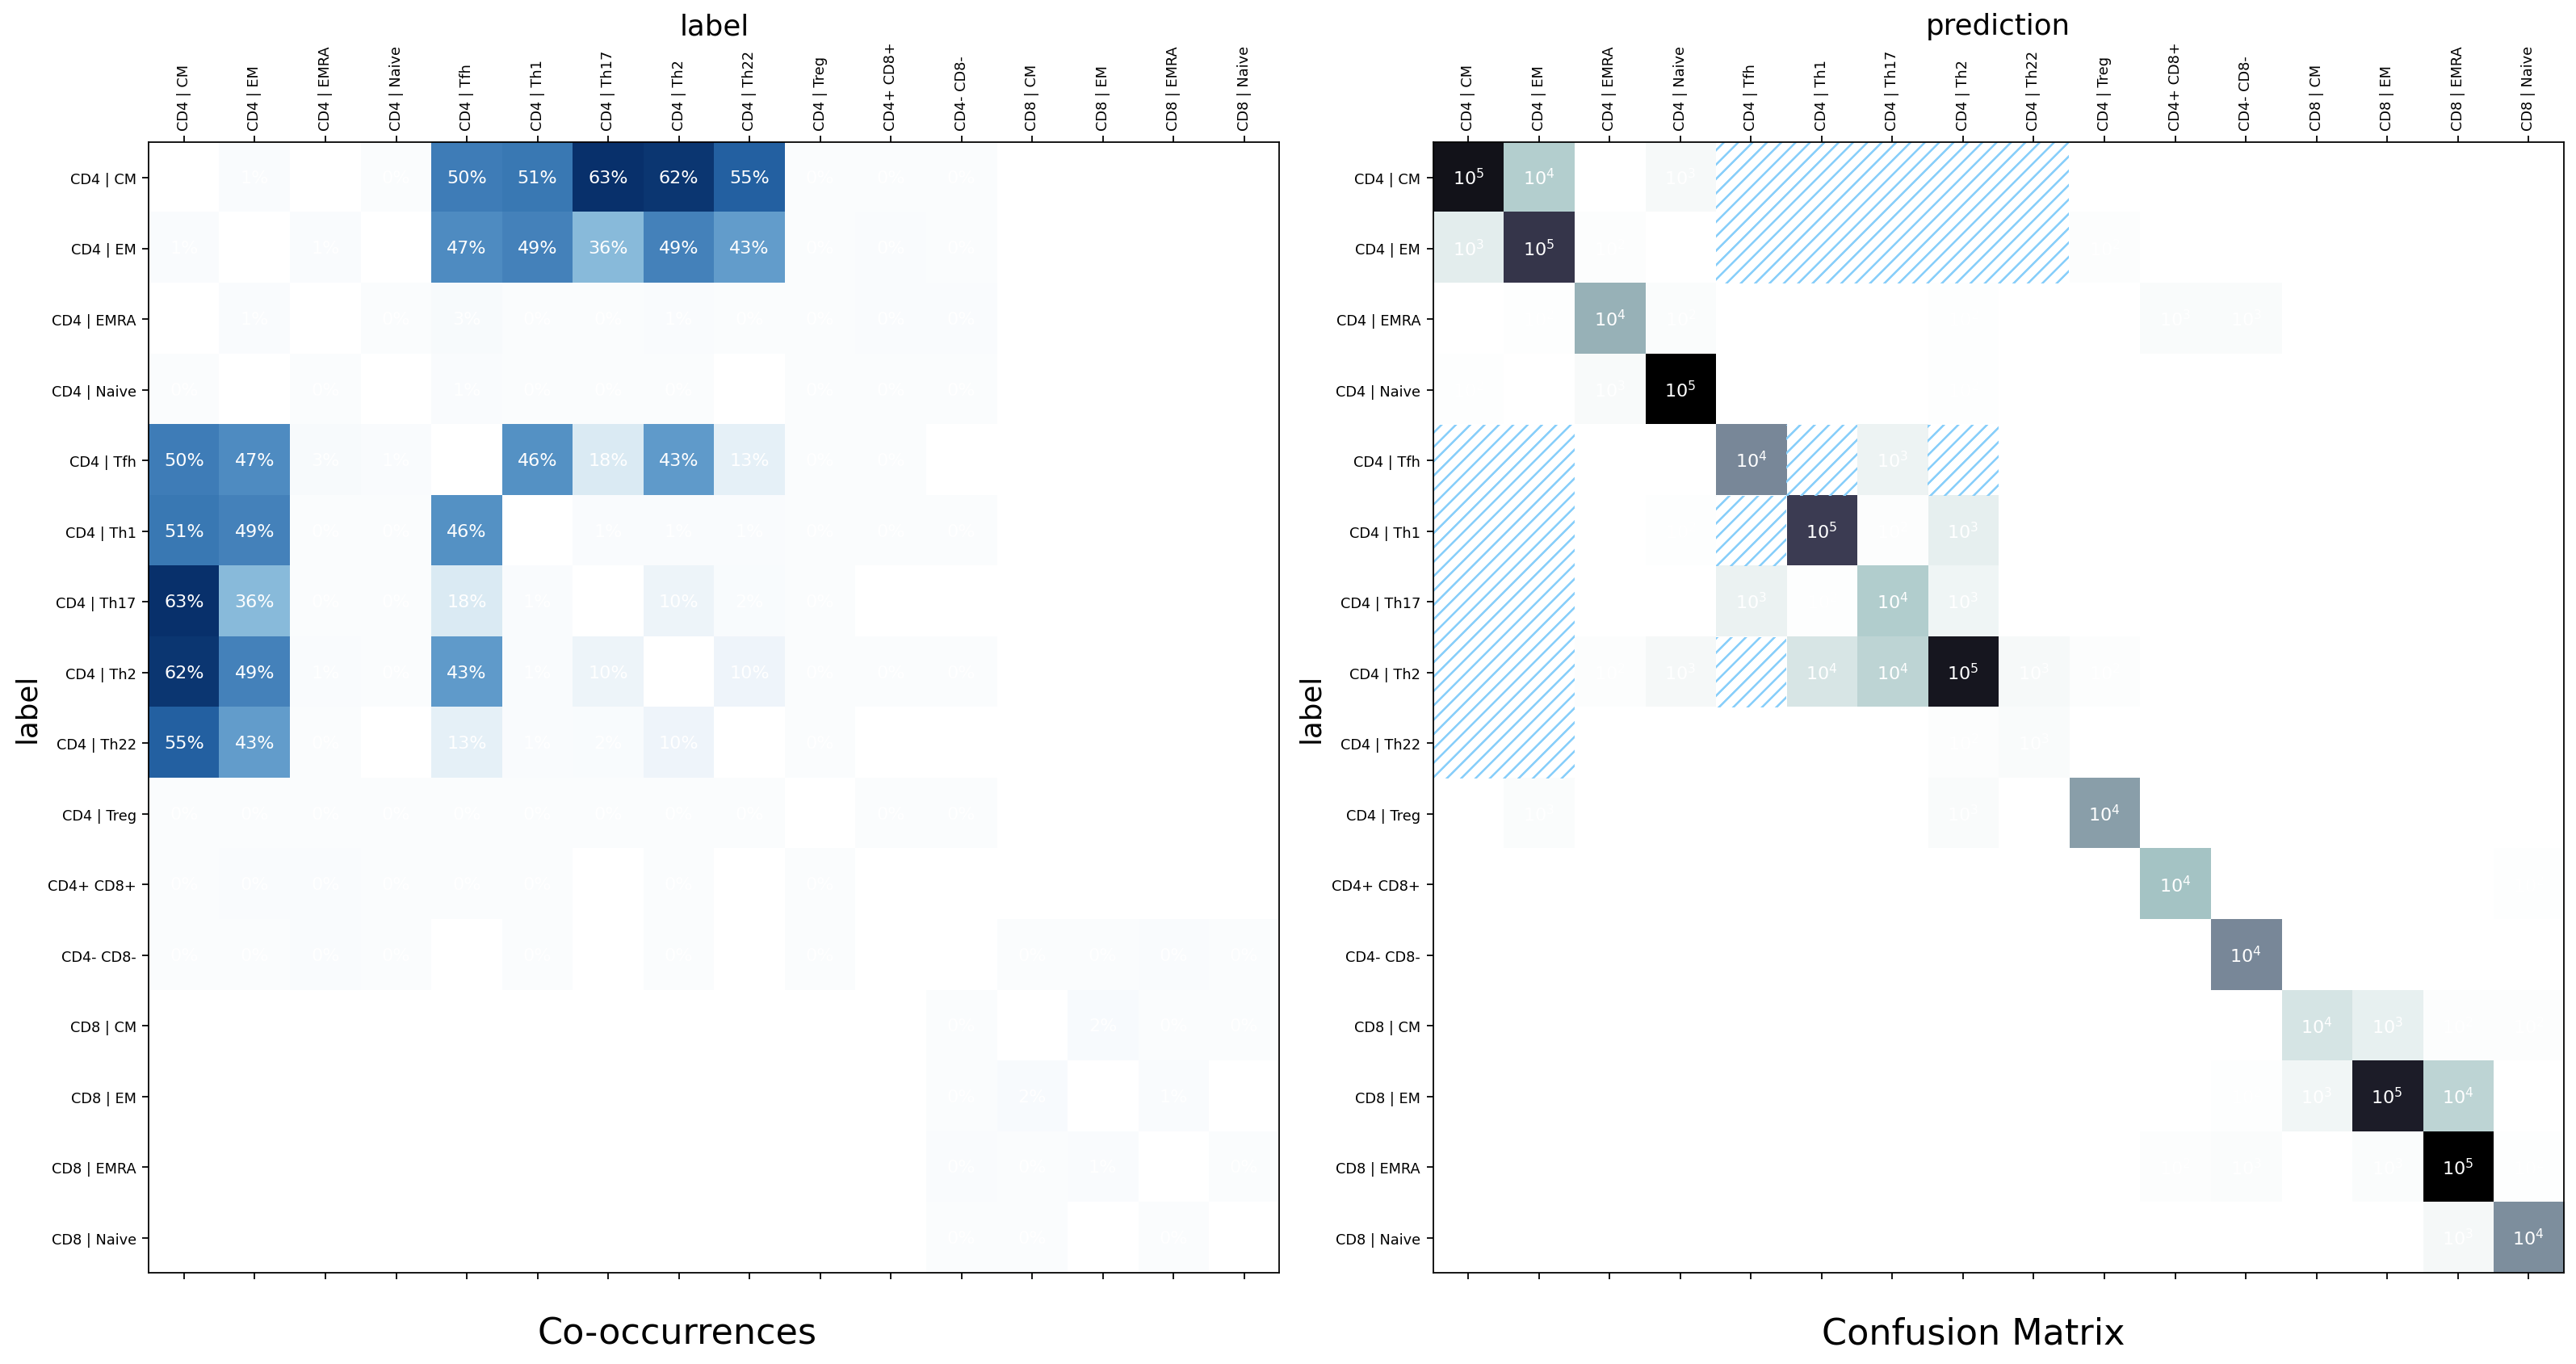

In [13]:
fig = figure(figsize=(20,10))

##################################################################
ax = fig.add_subplot(121)
ax.text(5, 16.5, "Co-occurrences",fontsize=20)

ax.matshow(cooccurrence,cmap='Blues',vmin=-0.1)
ax.grid(False)
    
for (i, j), z in ndenumerate(cooccurrence):
    if not isnan(z) :
        ax.text(j, i, '{:0.0f}%'.format(100*z),
                ha='center', va='center', color='white', fontsize=10)   

ax.xaxis.set_label_position('top') 
ax.set_xticklabels(['']+list(cooccurrence.columns.categories.to_list()),rotation=90)
ax.set_yticklabels(['']+list(cooccurrence.index.categories.to_list()))

ax.set_xlabel(cooccurrence.index.name,fontsize=16)
ax.set_ylabel(cooccurrence.index.name,fontsize=16)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))

##################################################################
ax = fig.add_subplot(122)
ax.text(5, 16.5, "Confusion Matrix",fontsize=20)

ax.matshow(log10(confusion_matrix+1e4),cmap='bone_r')
ax.grid(False)
    
for (i, j), z in ndenumerate(confusion_matrix):
    if not isnan(z) :
        ax.text(j, i, r'$10^{:0.0f}$'.format(log10(z)),
                ha='center', va='center', color='white', fontsize=10)   
        
for i,j in zip(*cooccurrence[cooccurrence>cooccurrence_threshold].replace({nan:0}).values.nonzero()) :
    ax.add_collection(PatchCollection( [ Rectangle((i-1/2,j-1/2),1,1) ],
        edgecolor='LightSkyBlue', facecolor='none', linewidth=0,  hatch='///'))
    
    ax.add_collection(PatchCollection( [ Rectangle((j-1/2,i-1/2),1,1) ],
        edgecolor='LightSkyBlue', facecolor='none', linewidth=0,  hatch='///'))


ax.xaxis.set_label_position('top') 
ax.set_xticklabels(['']+list(confusion_matrix.columns.categories.to_list()),rotation=90)
ax.set_yticklabels(['']+list(confusion_matrix.index.categories.to_list()))

ax.set_xlabel(confusion_matrix.columns.name,fontsize=16)
ax.set_ylabel(confusion_matrix.index.name,fontsize=16)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))

tight_layout()

/home/gszep/.local/lib/python3.6/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


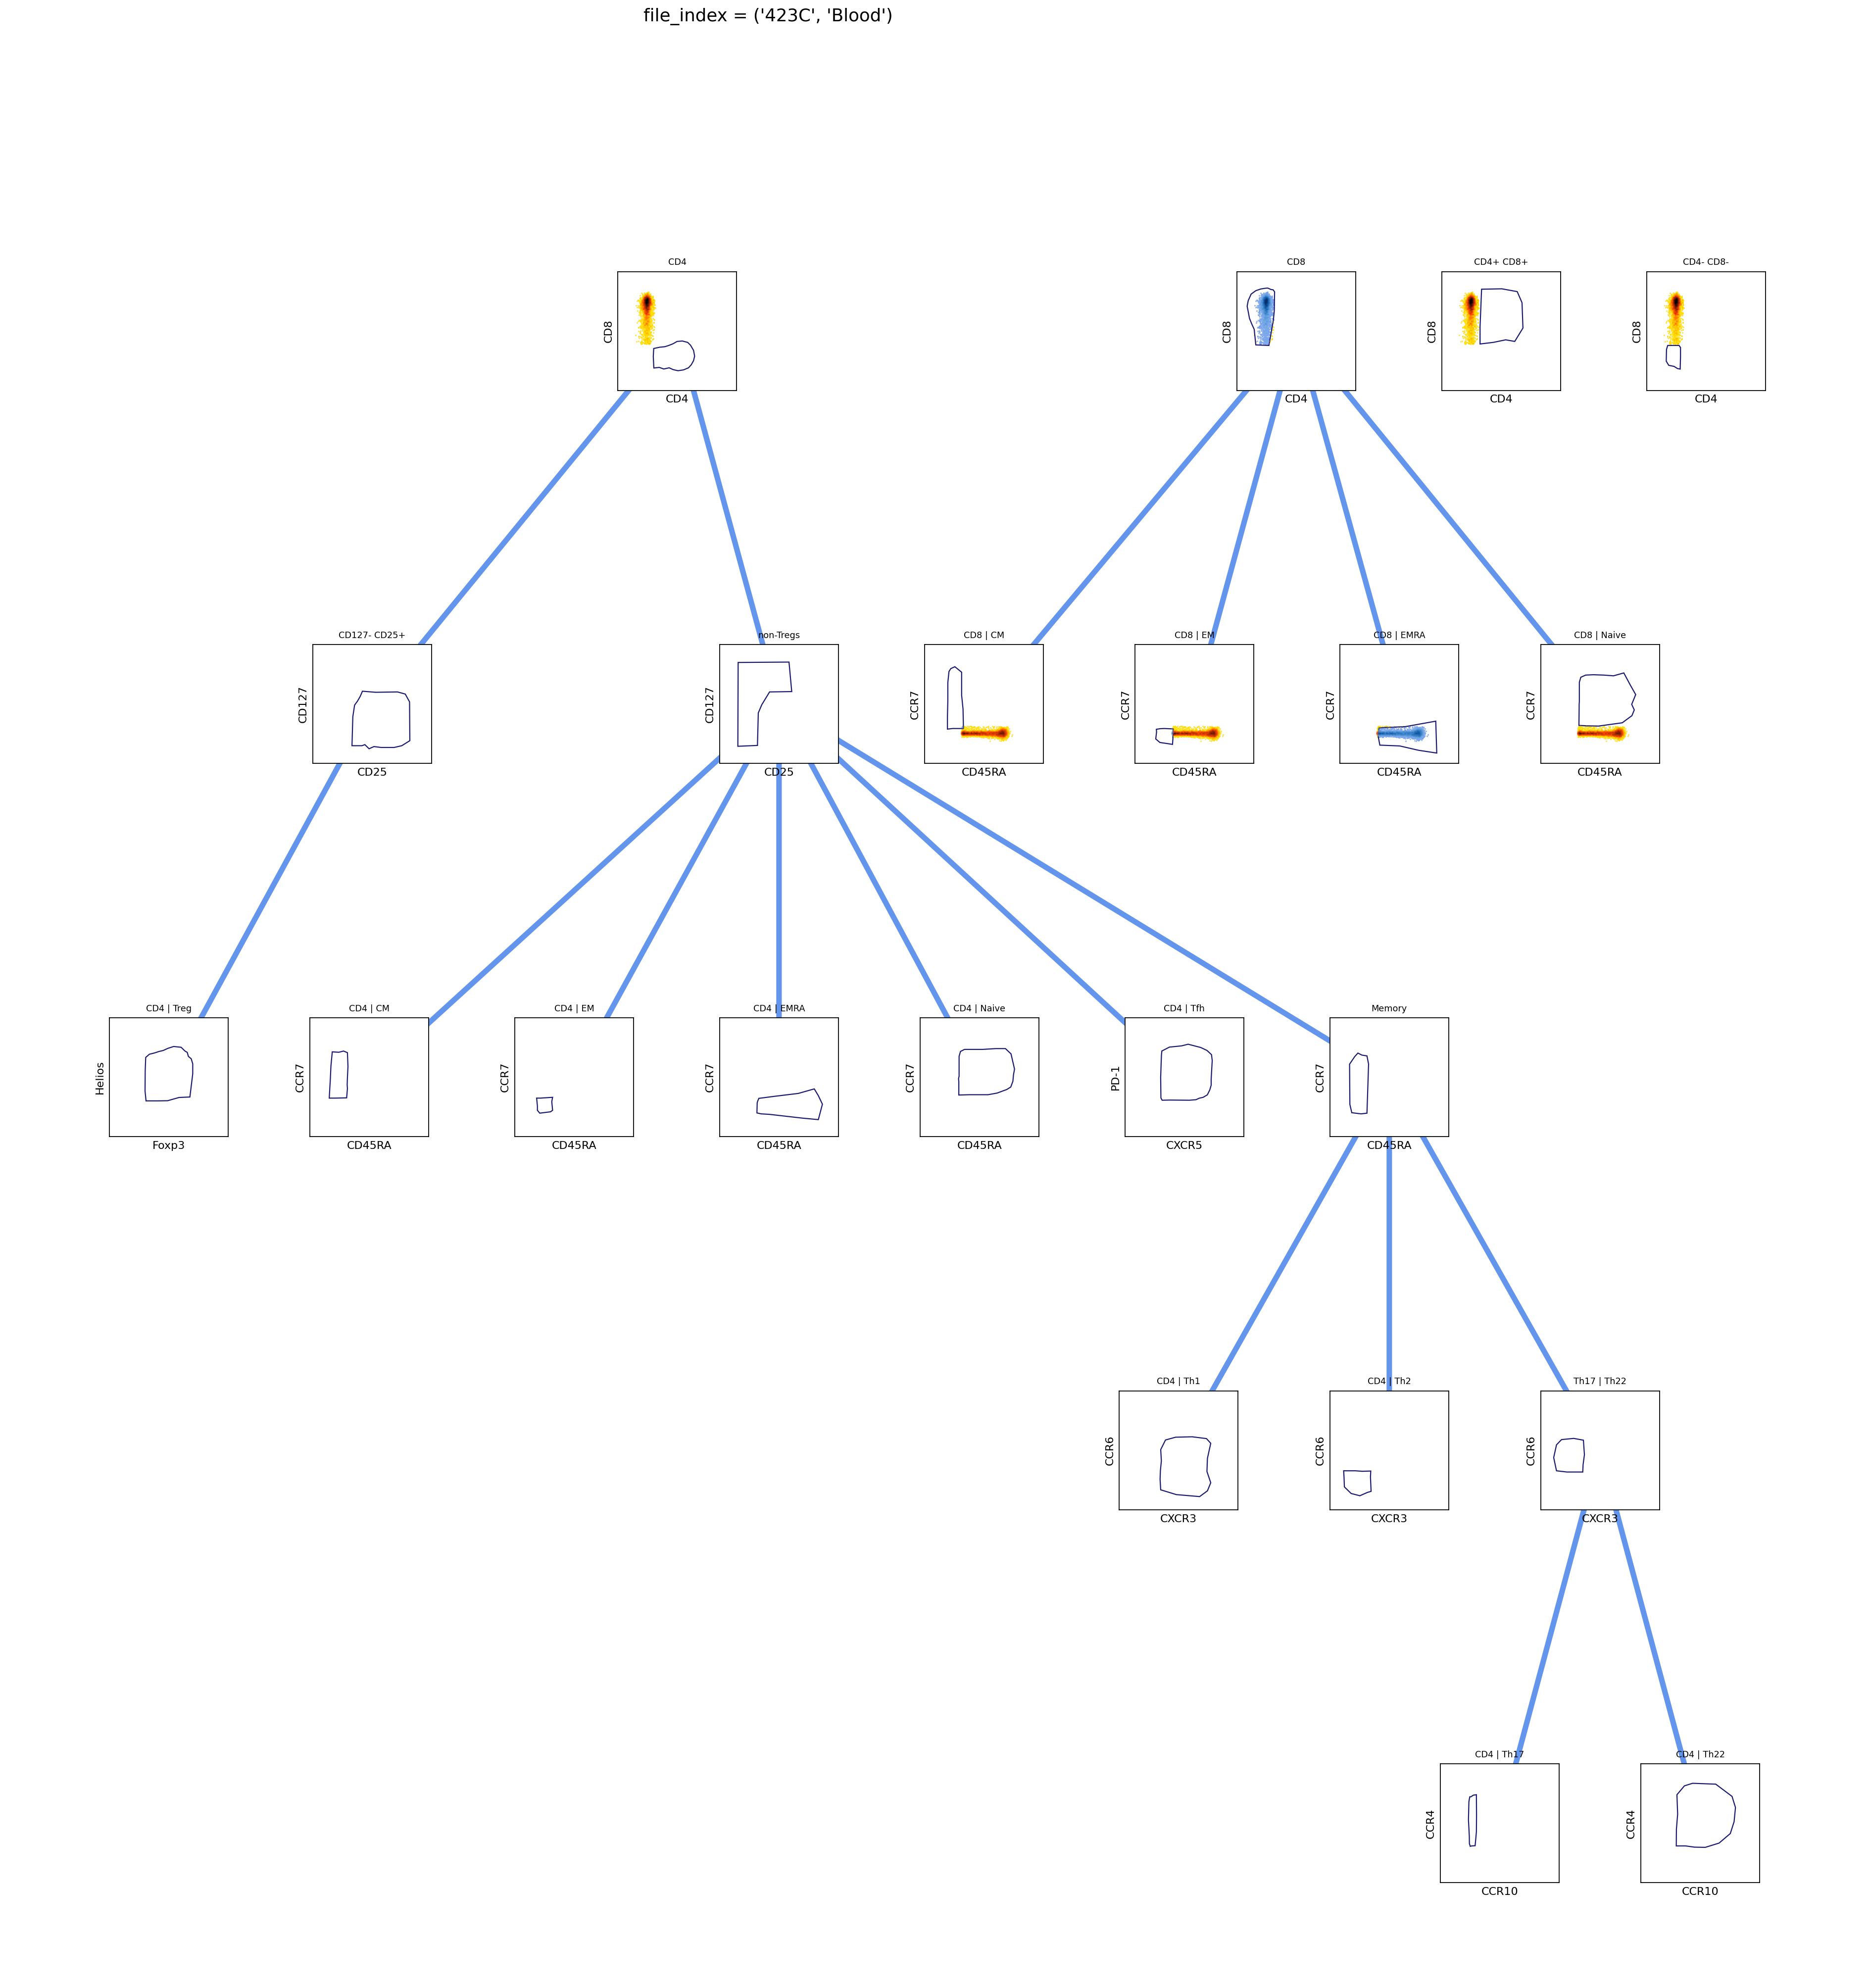

In [14]:
idx = clusters.reset_index().set_index('cluster').loc[
    predictions.index[predictions.prediction=='CD8 | EMRA']
].set_index(['patient','tissue','cell']).index

workspace.show(('423C','Blood'),filter=idx)

## Relative Abundance
Here we measure the relative abundance of primary cell populations within different tissues

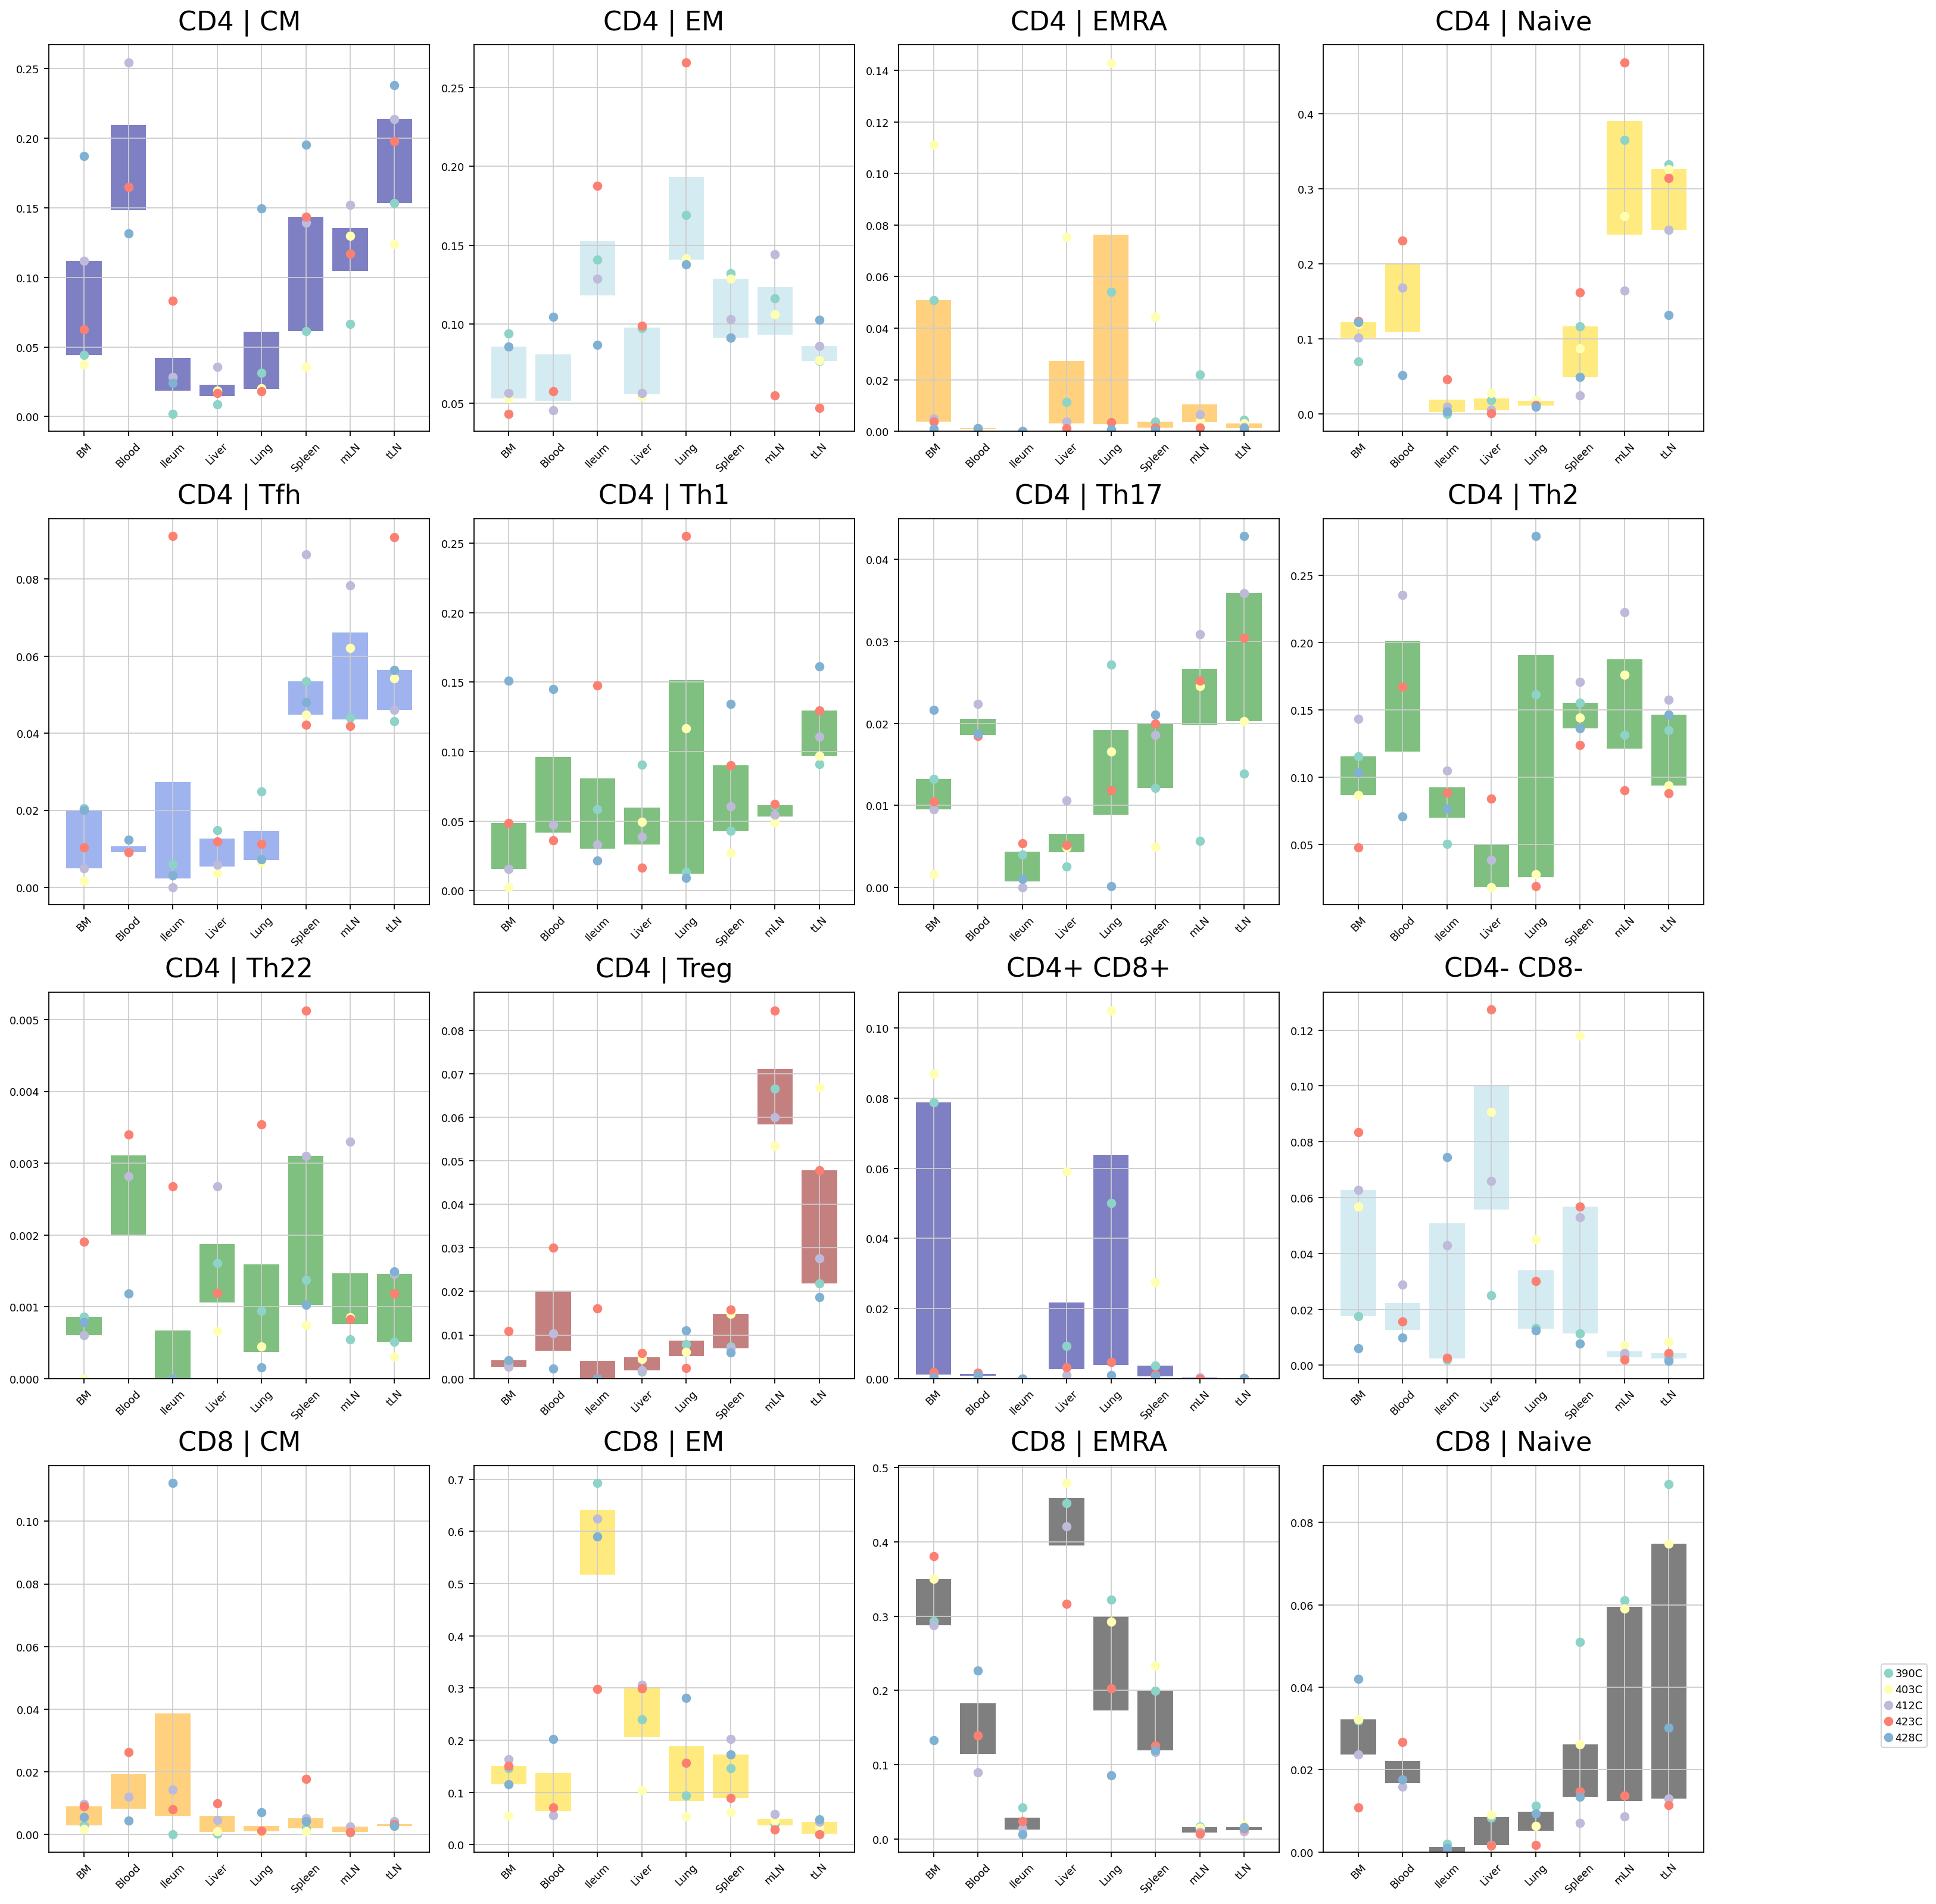

In [15]:
figure(figsize=(20,20))
known = clusters.join(predictions,how='left',on='cluster').drop(columns='cluster').dropna().reset_index('cell')
abundance = known.groupby(['prediction','tissue','patient']).cell.count()
abundance = abundance / known.groupby(['tissue','patient']).cell.count()

for i,population in enumerate(predictions.prediction.cat.categories) :
    ax = subplot(abundance.reset_index()['prediction'].cat.categories.size//4,4,i+1)
    ax.set_title(population,fontsize=20,y=1.02)
    
    population = abundance[:,:,population].unstack()

    bar( population.index, height=population.quantile(0.75,axis=1)-population.quantile(0.25,axis=1),
         bottom=population.quantile(0.25,axis=1), color=palette[i],alpha=0.5)
    
    plot(population,'o')
    xticks(rotation=45)

legend(population.columns, bbox_to_anchor=(1.6,0.5))
tight_layout()

In [16]:
######################################## use arcsinh fluorescence data for visualisation
cofactor = 250
fluorescence = arcsinh(sample.data/cofactor) - arcsinh(workspace.thresholds/cofactor)
dataset = clusters.join(predictions,how='left',on='cluster').join( fluorescence )

for level in range(dataset.index.nlevels-1) : # keep category dtypes
    dataset.index.set_levels( dataset.index.levels[level].astype('category'), level=level, inplace=True)

from scanpy import AnnData
dataset = AnnData( dataset.drop(columns=['cluster','prediction']).reset_index(drop=True),        
    obs = dataset[['cluster','prediction']].reset_index(),
    var = dataset.drop(columns=['cluster','prediction']).columns.to_frame().drop(columns=0) )

dataset = dataset[dataset.obs.tissue != 'Ileum']

/home/gszep/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/gszep/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [17]:
population_dict = {
    'CD8 | CM' : dataset.var.index.drop(['CD4','CD8','CD3','CCR7','CD45RA']),
    'CD8 | EM' : dataset.var.index.drop(['CD4','CD8','CD3','CCR7','CD45RA']),
    'CD8 | EMRA' : dataset.var.index.drop(['CD4','CD8','CD3','CCR7','CD45RA']),
    'CD8 | Naive' : dataset.var.index.drop(['CD4','CD8','CD3','CCR7','CD45RA']),

    'CD4 | CM' : dataset.var.index.drop(['CD4','CD8','CD3','CCR7','CD45RA']),
    'CD4 | EM' : dataset.var.index.drop(['CD4','CD8','CD3','CCR7','CD45RA']),
    'CD4 | EMRA' : dataset.var.index.drop(['CD4','CD8','CD3','CCR7','CD45RA']),
    'CD4 | Naive' : dataset.var.index.drop(['CD4','CD8','CD3','CCR7','CD45RA']),

#     'CD4 | Tfh' : dataset.var.index.drop(['CD4','CD8','CD3','CD127','PD-1']),
# #     'CD4 | Th1' : [],
#     'CD4 | Th2' : dataset.var.index.drop(['CD4','CD8','CD3']),
# #     'CD4 | Th17' : [],
#     'CD4 | Th22' : dataset.var.index.drop(['CD4','CD8','CD3']),
#     'CD4 | Treg' : dataset.var.index.drop(['CD4','CD8','CD3']),
#     'DP | CD4+ CD8+' : dataset.var.index.drop(['CD4','CD8','CD3']),
#     'DN | CD4- CD8-' : dataset.var.index.drop(['CD4','CD8','CD3'])
}

In [18]:
%%time
%%capture

fig = figure(figsize=(11.7,8.3))

for i,population_name in enumerate(population_dict.keys()) :

    ax = fig.add_subplot(1,len(population_dict),i+1)
    ax.title.set_text(population_name)

    population = dataset[dataset.obs.prediction == population_name]
    stacked_violin( population, population_dict[population_name],
        groupby='tissue',bw=0.1, palette=palette,
        ax=ax, swap_axes=False )

for ax in fig.axes:

    for element in ax.get_children():
        if isinstance(element,PolyCollection):
            path, = element.get_paths()

            try :
                vertices = path.vertices[path.vertices[:,1]<0]
                ax.add_collection(PolyCollection(vertices[None,...],color='white',alpha=0.75))
            except :
                pass

    if ax.get_ylabel() != '':
        ax.set_yticks([])
        
for ax in fig.axes[dataset.obs.tissue.cat.categories.size+1:] :
    ax.set_ylabel(None)
    
fig.subplots_adjust(wspace=0)

CPU times: user 4min 2s, sys: 4min 8s, total: 8min 10s
Wall time: 1min 24s


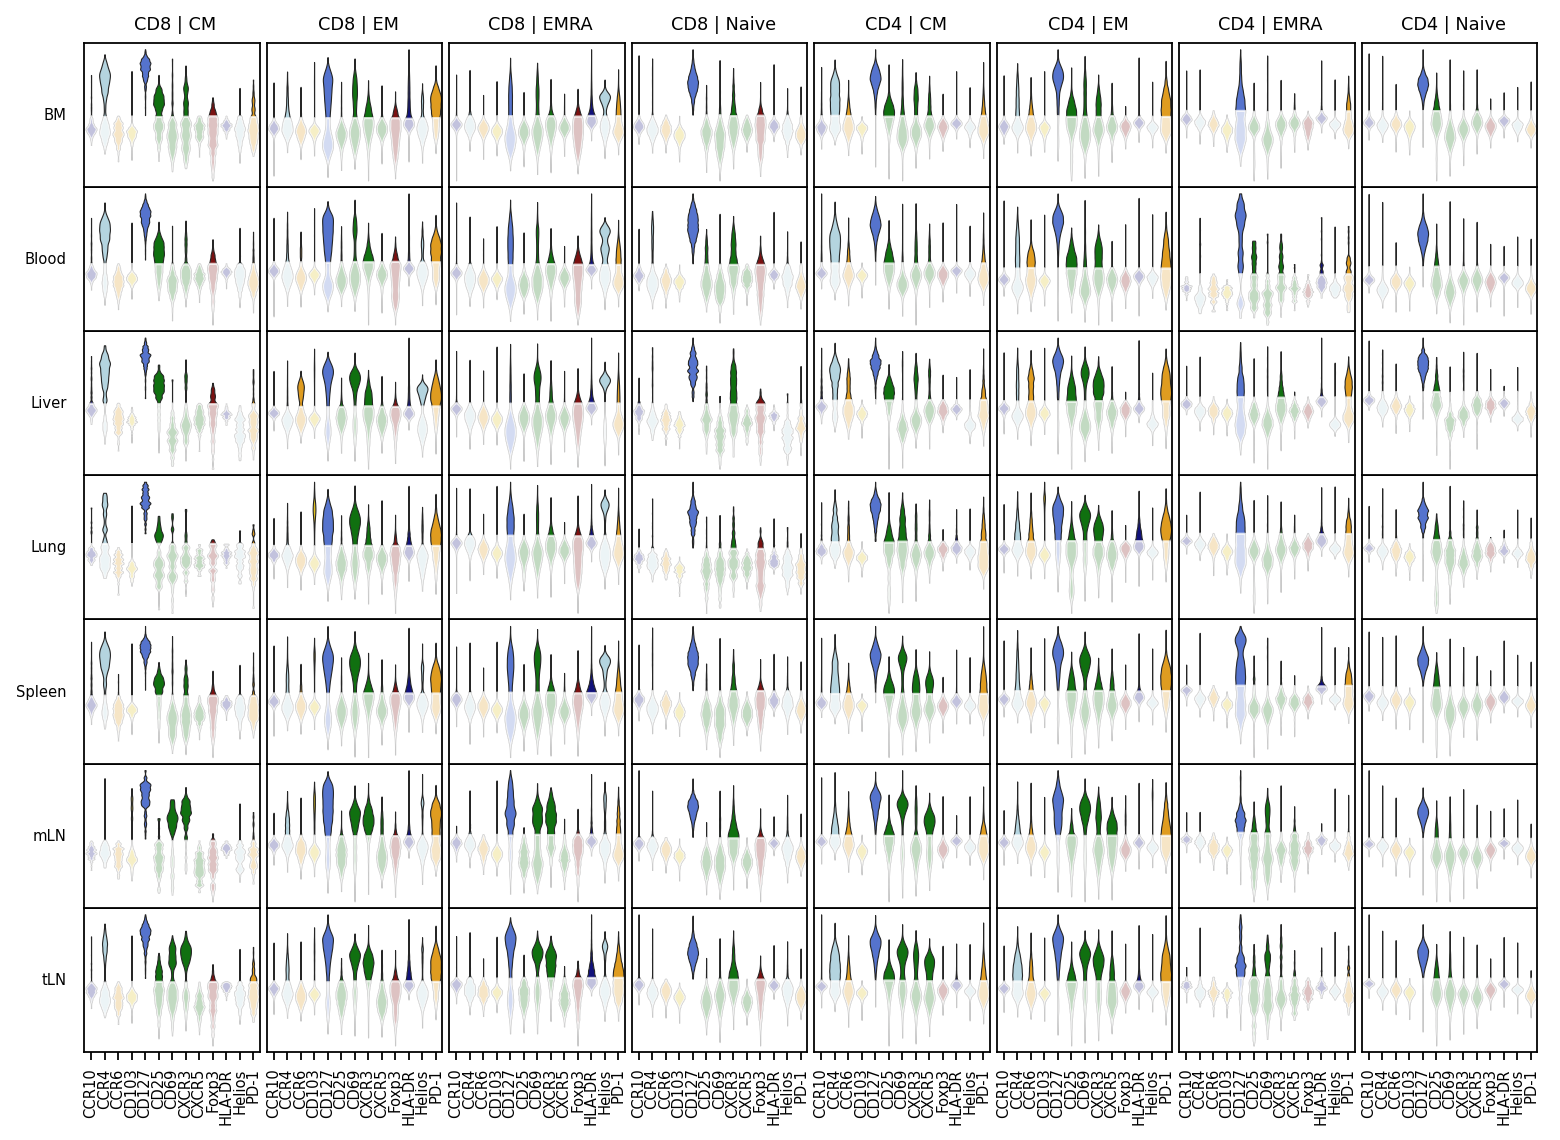

In [19]:
fig

In [289]:
%%capture
population_name = 'CD4 | Treg'
population = dataset[dataset.obs.prediction == population_name]

fig = figure(figsize=(8,4))
fig.suptitle(population_name, fontsize=16, y=1.02)

ax = fig.add_subplot(111)
stacked_violin(population, dataset.var.index, groupby='tissue', scale='count',
   bw=0.1, color=palette[i], dendrogram=False, ax=ax)

for ax in fig.axes:

    for element in ax.get_children():
        if isinstance(element,PolyCollection):
            path, = element.get_paths()

            try :
                vertices = path.vertices[path.vertices[:,1]<0]
                ax.add_collection(PolyCollection(vertices[None,...],color='white',alpha=0.75))
            except :
                pass

    if ax.get_ylabel() != '':
        ax.set_yticks([])

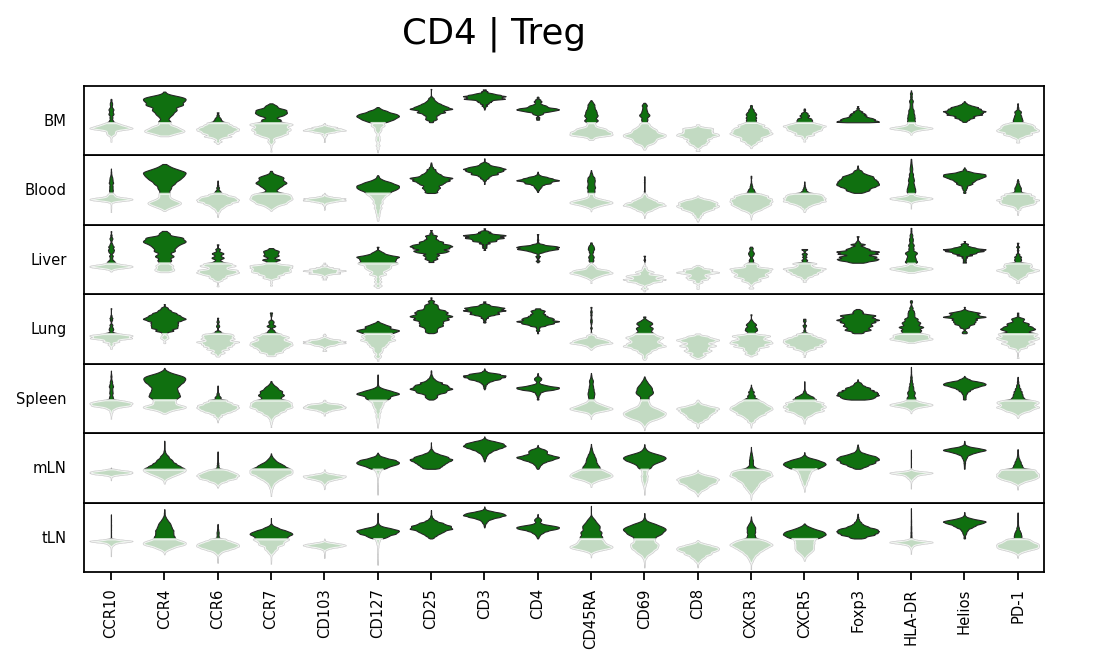

In [290]:
fig

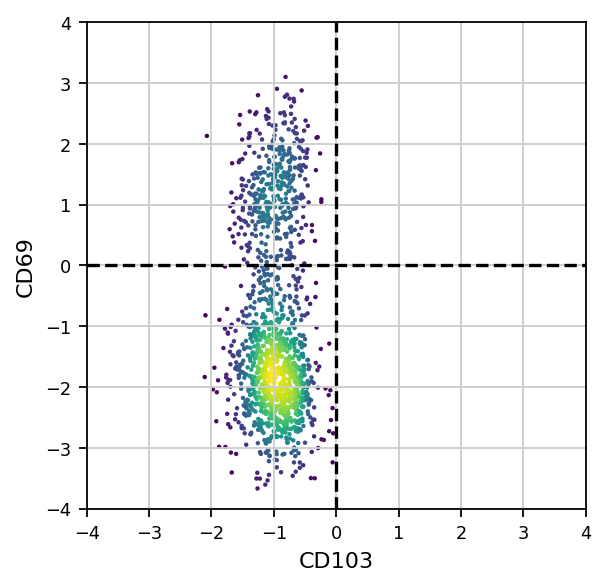

In [296]:
from scipy.stats import gaussian_kde

tissue_name = 'Spleen'
markers = ('CD103','CD69')

X = dataset[dataset.obs.prediction==population_name]
X = X[X.obs.tissue==tissue_name]
X = X[:,[ list(X.var.index).index(marker) for marker in markers ]]

scatter(*X.X.T, c=gaussian_kde(X.X.T)(X.X.T),alpha=1,s=1)

xlim(-4,4)
ylim(-4,4)

xlabel(markers[0],fontsize=10)
ylabel(markers[1],fontsize=10)

axvline(0,color='k',linestyle='--')
axhline(0,color='k',linestyle='--')
#savefig('test.svg')

In [68]:
signatures = dataset.obs.groupby(['prediction','tissue','cluster']) \
.cell.count().reset_index(['prediction','tissue'])

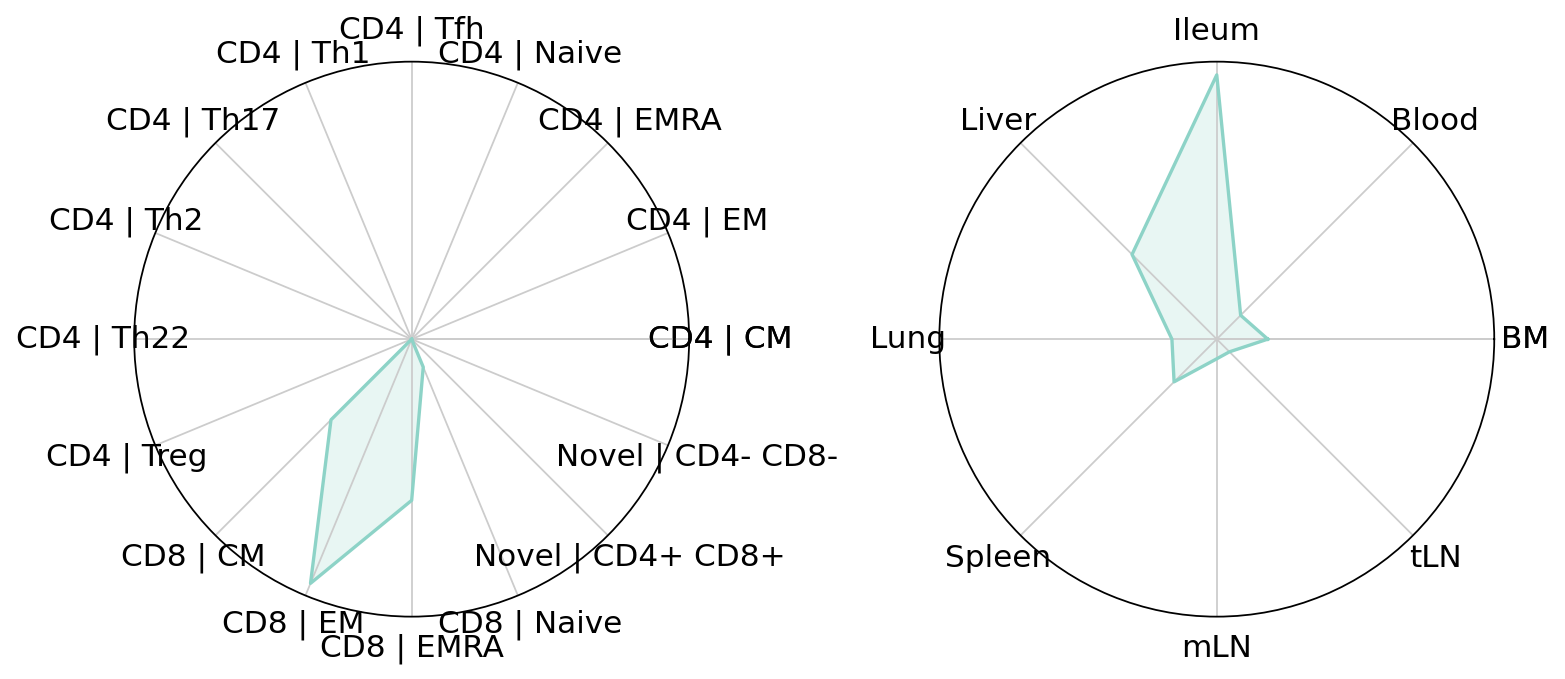

In [74]:
mask = signatures.index.str.match('110[0-1]{13}1[0-1]')
assert any(mask), 'no expression patterns match'
fig = figure(figsize=(10,5))

fig.add_subplot(121,projection='polar')
probability = signatures[mask].groupby('prediction').sum() / signatures.groupby('prediction').sum()
probability = probability.cell.append(Series(probability.cell[0],index=[probability.iloc[0].name]))

theta = linspace(0,2*pi,probability.index.size)
polar(theta,probability)

fill_between(theta, probability, alpha=0.2)
xticks(theta,probability.index); yticks([]);

fig.add_subplot(122,projection='polar')
probability = signatures[mask].groupby('tissue').sum() / signatures.groupby('tissue').sum()
probability = probability.cell.append(Series(probability.cell[0],index=[probability.iloc[0].name]))

theta = linspace(0,2*pi,probability.index.size)
polar(theta,probability)

fill_between(theta, probability, alpha=0.2)
xticks(theta,probability.index); yticks([]);
tight_layout()

## Type Topology Visualisation
Here we employ dimensionality reduction techniques to visualise the cell type topology, and the relative abundance of cell types in different tissues.

In [ ]:
################################################# dimensionality reduction
neighbors(dataset,n_neighbors=10)
umap(dataset)

In [ ]:
fig = plot_umap(dataset, color=dataset.var.index, ncols=5, return_fig=True,
                color_map='RdYlGn',vmin=-1.5,vmax=1.5)

for ax in fig.axes :
    
    ax.set_xlabel('')
    ax.set_ylabel('')

    if ax.collections[0].colorbar != None :
        ax.collections[0].colorbar.remove()

fig.colorbar(fig.axes[0].collections[0], ax=fig.axes, shrink=0.95)
fig.set_size_inches((19,10))

In [ ]:
dataset.uns['prediction_colors'] = [
    'darkblue','lightblue','orange','gold',
    'royalblue','green','green','green','green','darkred',
    'darkblue','lightblue','orange','gold',
    'black']

fig = plot_umap(dataset, color='prediction', title='Predictions',
                return_fig=True, size=10)

fig.set_size_inches((10,10))

In [ ]:
############################################################# dimensionally reduced per tissue and cluster
fig = figure(figsize=(17,8))
fig.suptitle('Uniform Manifold Approximation Projection',x=0.55,y=1.02)
[projection],_ = _get_data_points( dataset, 'umap', '2d', None, None, None )

for i,tissue in enumerate(dataset.obs.tissue.cat.categories) :
    
    subplot(2,4,i+1)
    title(tissue,fontsize=16,y=1.02)

    lines = []
    for j,prediction in enumerate(dataset.obs.prediction.cat.categories) :
        mask = (dataset.obs.prediction==prediction)&(dataset.obs.tissue==tissue)
        points = projection[mask]
        
        line, = plot(points[:,0],points[:,1],'.',ms=1,label=prediction, color=dataset.uns['prediction_colors'][j] )
        xticks([], []); yticks([], [])
        lines += [line]
        
        
figlegend( lines, dataset.obs.prediction.cat.categories, loc = (0.02,0.15), ncol=1,
          fontsize=16, markerscale=10, frameon=False);

In [ ]:
mask = dataset.obs.prediction == 'CD4 | Treg'
population = dataset[mask]

dendrogram(population, groupby='cluster')
stacked_violin(population, dataset.var.index, groupby='cluster', 
               dendrogram=False, swap_axes=True, figsize=(3,12));

In [ ]:
mask = dataset.obs.prediction == 'CD4 | Treg'
population = dataset[mask]

############################################################# dimensionally reduced per tissue and cluster
fig = figure(figsize=(17,8))
fig.suptitle('Uniform Manifold Approximation Projection',x=0.55,y=1.02)
[projection],_ = _get_data_points( population, 'umap', '2d', None, None, None )

for i,tissue in enumerate(sort(population.obs.tissue.unique())) :
    
    subplot(2,4,i+1)
    title(tissue,fontsize=16,y=1.02)

    lines = []
    for j,leiden in enumerate(sort(population.obs.leiden.unique())) :
        mask = (population.obs.leiden==leiden)&(population.obs.tissue==tissue)
        points = projection[mask]
        
        line, = plot(points[:,0],points[:,1],'.',ms=1,label=leiden )
        xticks([], []); yticks([], [])
        lines += [line]
        
        
figlegend( lines, sort(population.obs.leiden.unique()), loc = (0.02,0.15), ncol=1,
          fontsize=16, markerscale=10, frameon=False);